In [64]:
""" Molecular Dynamics Simulation (Object-Oriented Version)
This code simulates the dynamics of atoms governed by the Lennard-Jones potential at the molecular scale.
Authors: Borui Xu, Lucien Tsai, Yeqi Chu
"""

from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod
from typing import List, Tuple, Optional, Set, Dict

class Atom:
    """Class representing an individual atom in the simulation."""
    def __init__(
        self, 
        position: np.ndarray, 
        velocity: np.ndarray,
        mass: float, 
        epsilon: float, 
        sigma: float) -> None:
        
        self.position: np.ndarray = np.array(position, dtype=float)
        self.velocity: np.ndarray = np.array(velocity, dtype=float)
        self.mass: float = mass
        self.epsilon: float = epsilon
        self.sigma: float = sigma
        self.force: np.ndarray = np.zeros(3, dtype=float)
        
class Potential(ABC):
    """Abstract base class for different potentials."""
    def __init__(self, pairwise_interactions: Optional[Set[Tuple[int, int]]] = None) -> None:
        """
        Args:
            pairwise_interactions: Optional set of (i, j) tuples specifying which atom pairs
                                   should interact. If None, all atom pairs interact.
                                   
            Note: here (i, j) is oriented, and if you want both (0,1) and (1,0) to be valid, 
                  you need to have both (0,1) and (1,0) in the set.
        """
        self.pairwise_interactions = pairwise_interactions  # Set of tuples (i, j)

    @abstractmethod
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        """Compute forces acting on all atoms."""
        pass
    
class Constraint(ABC):
    """Abstract base class for constraints."""
    @abstractmethod
    def apply(self, atoms: List[Atom], box_size: float) -> None:
        """Directly modify atoms to enforce constraints."""
        pass
        
class LennardJonesPotential(Potential):
    """A concrete class implementing the Lennard-Jones potential."""
    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        # Reset all forces
        for atom in atoms:
            atom.force.fill(0.0)

        num_atoms: int = len(atoms)
        for i in range(num_atoms):
            atom_i: Atom = atoms[i]
            for j in range(num_atoms):
                if i == j:  # Skip self-interaction
                    continue

                # If defined pairwise_interactions，check if (i, j) is in it
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue

                atom_j: Atom = atoms[j]
                delta: np.ndarray = atom_i.position - atom_j.position
                # Apply minimum image convention for periodic boundaries
                delta -= box_size * np.round(delta / box_size)
                r: float = float(np.linalg.norm(delta))
                if r == 0:
                    continue
                epsilon_ij: float = np.sqrt(atom_i.epsilon * atom_j.epsilon)
                sigma_ij: float = (atom_i.sigma + atom_j.sigma) / 2
                F_mag: float = 4 * epsilon_ij * (
                    (12 * sigma_ij**12 / r**13) - (6 * sigma_ij**6 / r**7)
                )
                force_vector: np.ndarray = (F_mag / r) * delta
                atom_i.force += force_vector
                atom_j.force -= force_vector  # Newton's third law
                
class LinearSpringPotential(Potential):
    """A linear spring potential between pairs of atoms.
    
    When the distance between two atoms equals the rest length r0, the force is zero.
    If the distance deviates from r0, a linear restoring force acts on both atoms.
    """
    def __init__(
        self, 
        rest_lengths: Dict[Tuple[int, int], float], 
        k: float = 1.0, 
        pairwise_interactions: Optional[Set[Tuple[int, int]]] = None
    ) -> None:
        super().__init__(pairwise_interactions)
        self.rest_lengths = rest_lengths
        self.k = k

    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        # Reset all forces
        for atom in atoms:
            atom.force.fill(0.0)

        num_atoms = len(atoms)
        for i in range(num_atoms):
            atom_i = atoms[i]
            for j in range(i + 1, num_atoms):
                atom_j = atoms[j]

                # If we have defined pairwise_interactions, check if (i, j) is included
                if self.pairwise_interactions is not None:
                    if (i, j) not in self.pairwise_interactions and (j, i) not in self.pairwise_interactions:
                        continue

                # Check if we have a rest length defined for this pair
                if (i, j) in self.rest_lengths:
                    r0 = self.rest_lengths[(i, j)]
                elif (j, i) in self.rest_lengths:
                    r0 = self.rest_lengths[(j, i)]
                else:
                    # If no rest length is defined for this pair, skip
                    continue

                delta = atom_i.position - atom_j.position
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                if r == 0:
                    # If atoms overlap exactly, handle carefully or skip
                    continue

                # Compute displacement from rest length
                dr = r - r0
                if dr != 0.0:
                    # Force magnitude
                    F_mag = self.k * dr
                    # Direction
                    direction = delta / r
                    force_vector = F_mag * direction
                    # Apply equal and opposite forces
                    atom_i.force -= force_vector
                    atom_j.force += force_vector

                
class FixPointConstraint(Constraint):
    """A constraint that fixes certain atoms at a given spatial position."""
    def __init__(self, fixed_points: Dict[int, Tuple[float, float, float]]) -> None:
        """
        fixed_points: {atom_index: (x_fixed, y_fixed, z_fixed)} 
        """
        self.fixed_points = fixed_points

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        for idx, atom in enumerate(atoms):
            if idx in self.fixed_points:
                # Sets the atomic position to the specified coordinate point
                fixed_pos = self.fixed_points[idx]
                atom.position[:] = fixed_pos
                atom.velocity.fill(0.0)
                
class PartialFixConstraint(Constraint):
    """A constraint that fixes certain atoms in specific coordinate directions.
    
    partial_fixed_points: {atom_index: (x_val, y_val, z_val)}
      - x_val, y_val, z_val can be None or float.
      - If float, that coordinate of the atom is fixed to this value.
      - If None, that coordinate is not constrained.
    """

    def __init__(self, partial_fixed_points: Dict[int, Tuple[Optional[float], Optional[float], Optional[float]]]) -> None:
        self.partial_fixed_points = partial_fixed_points

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        for idx, atom in enumerate(atoms):
            if idx in self.partial_fixed_points:
                x_val, y_val, z_val = self.partial_fixed_points[idx]

                # Constrain x coordinate if specified
                if x_val is not None:
                    atom.position[0] = x_val
                    atom.velocity[0] = 0.0  # Set velocity to zero to prevent drift

                # Constrain y coordinate if specified
                if y_val is not None:
                    atom.position[1] = y_val
                    atom.velocity[1] = 0.0

                # Constrain z coordinate if specified
                if z_val is not None:
                    atom.position[2] = z_val
                    atom.velocity[2] = 0.0

                # If needed, you could apply box boundary conditions here:
                # atom.position %= box_size
                # However, if the position is fixed, periodic boundaries may not be desired.


class FixedDistanceConstraint(Constraint):
    """A constraint that fixes certain atom pairs at a given distance r0."""
    def __init__(
        self, 
        fixed_distances: Dict[Tuple[int, int], float], 
        pairwise_interactions: Optional[Set[Tuple[int,int]]] = None
    ) -> None:
        """
        fixed_distances: {(i,j): r0} means that the target distance of an atom pair (i,j) is r0. 
                         It is usually recommended to also specify (j,i) to make the constraint symmetric. 
        pairwise_interactions: If given, apply this constraint only to these pairs.
        """
        self.fixed_distances = fixed_distances
        self.pairwise_interactions = pairwise_interactions

    def apply(self, atoms: List[Atom], box_size: float) -> None:
        num_atoms = len(atoms)
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i == j:
                    continue
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue
                if (i, j) not in self.fixed_distances:
                    continue

                atom_i = atoms[i]
                atom_j = atoms[j]

                delta = atom_i.position - atom_j.position
                # Minimum mirror principle (if periodic boundary conditions are required)
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                r0 = self.fixed_distances[(i, j)]

                if r == 0:
                    # If two points coincide, just shift one of them by a random point
                    continue

                # If r! = r0, the position is adjusted
                if r != r0:
                    excess = r - r0
                    direction = delta / r
                    # Assume equal distribution correction
                    correction = direction * (excess / 2.0)

                    # Adjust the position of the atoms so that the final distance changes back to r0
                    atom_i.position -= correction
                    atom_j.position += correction

                    # The coordinates are modified with periodic boundary conditions
                    atom_i.position %= box_size
                    atom_j.position %= box_size
                
class MolecularDynamicsSimulator:
    def __init__(
        self, 
        atoms: List[Atom], 
        box_size: float, 
        total_time: float, 
        total_steps: int,
        potential: Potential,
        constraints: Optional[List[Constraint]] = None
    ) -> None:
        self.atoms = atoms
        self.box_size = box_size
        self.total_time = total_time
        self.total_steps = total_steps
        self.dt = total_time / total_steps
        self.num_atoms = len(atoms)
        self.positions = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.velocities = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.potential = potential
        self.constraints = constraints if constraints is not None else []

    def integrate(self) -> None:
        # Initialize positions and velocities
        for idx, atom in enumerate(self.atoms):
            self.positions[0, idx, :] = atom.position
            self.velocities[0, idx, :] = atom.velocity

        # Compute initial forces
        self.potential.compute_forces(self.atoms, self.box_size)

        # Time integration loop
        for step in range(1, self.total_steps + 1):
            # Update positions
            for idx, atom in enumerate(self.atoms):
                atom.position += atom.velocity * self.dt + (atom.force / (2 * atom.mass)) * self.dt**2
                atom.position %= self.box_size

            # Apply constraints
            for c in self.constraints:
                c.apply(self.atoms, self.box_size)

            # Compute new forces
            self.potential.compute_forces(self.atoms, self.box_size)

            # Update velocities
            for idx, atom in enumerate(self.atoms):
                atom.velocity += (atom.force / atom.mass) * self.dt
                self.positions[step, idx, :] = atom.position
                self.velocities[step, idx, :] = atom.velocity

class MolecularDynamicsSimulator:
    def __init__(
        self, 
        atoms: List[Atom], 
        box_size: float, 
        total_time: float, 
        total_steps: int,
        potential: Potential,
        constraints: Optional[List[Constraint]] = None
    ) -> None:
        self.atoms = atoms
        self.box_size = box_size
        self.total_time = total_time
        self.total_steps = total_steps
        self.dt = total_time / total_steps
        self.num_atoms = len(atoms)
        self.positions = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.velocities = np.zeros((total_steps + 1, self.num_atoms, 3), dtype=float)
        self.potential = potential
        self.constraints = constraints if constraints is not None else []

    def integrate(self) -> None:
        # Initialize positions and velocities
        for idx, atom in enumerate(self.atoms):
            self.positions[0, idx, :] = atom.position
            self.velocities[0, idx, :] = atom.velocity

        # Compute initial forces
        self.potential.compute_forces(self.atoms, self.box_size)

        # Time integration loop
        for step in range(1, self.total_steps + 1):
            # Update positions
            for idx, atom in enumerate(self.atoms):
                atom.position += atom.velocity * self.dt + (atom.force / (2 * atom.mass)) * self.dt**2
                atom.position %= self.box_size

            # Apply constraints
            for c in self.constraints:
                c.apply(self.atoms, self.box_size)

            # Compute new forces
            self.potential.compute_forces(self.atoms, self.box_size)

            # Update velocities
            for idx, atom in enumerate(self.atoms):
                atom.velocity += (atom.force / atom.mass) * self.dt
                self.positions[step, idx, :] = atom.position
                self.velocities[step, idx, :] = atom.velocity

    def animate(
        self, 
        filename: str = 'md_simulation.gif', 
        interval: int = 50, 
        save_gif: bool = True,
        elev: float = 30,
        azim: float = 60,
        lj_pairs: Optional[List[Tuple[int,int]]] = None,
        fixed_pairs: Optional[List[Tuple[int,int]]] = None
    ) -> None:
        # If no pairs are given, default to empty lists
        if lj_pairs is None:
            lj_pairs = []
        if fixed_pairs is None:
            fixed_pairs = []

        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Set initial view
        ax.set_xlim(0, self.box_size)
        ax.set_ylim(0, self.box_size)
        ax.set_zlim(0, self.box_size)
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('X (Å)')
        ax.set_ylabel('Y (Å)')
        ax.set_zlabel('Z (Å)')
        ax.set_title('Molecular Dynamics Simulation - 3D View')

        # Initial scatter
        frame_positions = self.positions[0]
        scat = ax.scatter(frame_positions[:,0], frame_positions[:,1], frame_positions[:,2], s=100, c='blue')

        def update(frame: int):
            ax.clear()
            ax.set_xlim(0, self.box_size)
            ax.set_ylim(0, self.box_size)
            ax.set_zlim(0, self.box_size)
            ax.view_init(elev=elev, azim=azim)
            ax.set_xlabel('X (Å)')
            ax.set_ylabel('Y (Å)')
            ax.set_zlabel('Z (Å)')
            ax.set_title(f'Molecular Dynamics Simulation (Time: {frame * self.dt:.2f} ns)')

            current_positions = self.positions[frame]
            scat = ax.scatter(current_positions[:,0], current_positions[:,1], current_positions[:,2], s=100, c='blue')

            # Draw LJ potential lines (black dashed)
            for (i, j) in lj_pairs:
                xi, yi, zi = current_positions[i]
                xj, yj, zj = current_positions[j]
                ax.plot([xi, xj], [yi, yj], [zi, zj], "k--")

            # Draw fixed distance lines (red solid)
            for (i, j) in fixed_pairs:
                xi, yi, zi = current_positions[i]
                xj, yj, zj = current_positions[j]
                ax.plot([xi, xj], [yi, yj], [zi, zj], "r-")

            return scat,

        ani = FuncAnimation(
            fig,
            update,
            frames=range(0, self.total_steps + 1, max(1, self.total_steps // 100)),
            interval=interval,
            blit=True
        )

        if save_gif:
            ani.save(filename, writer='pillow', fps=20)
        plt.show()


In [27]:
!mypy main.py

Success: no issues found in 1 source file


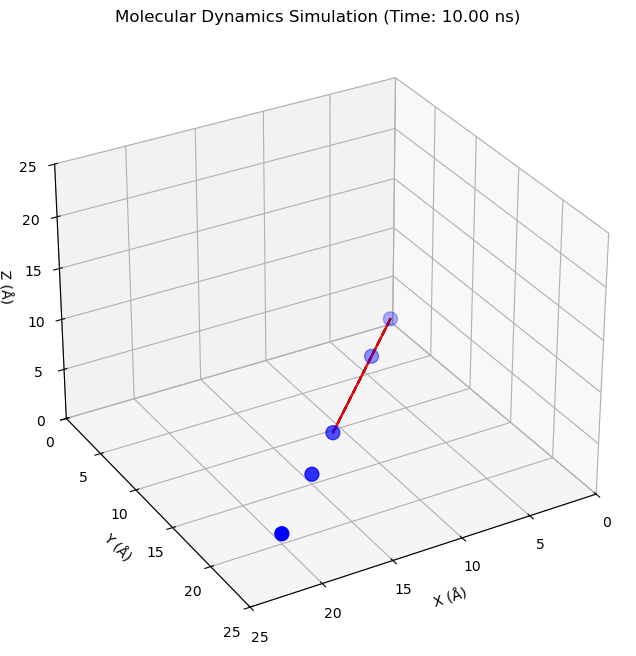

In [59]:
# Simulation parameters
box_size: float = 25.0  # Units in Å
total_time: float = 10.0  # Units in ns
total_steps: int = 1000

# Create atoms
initial_positions: np.ndarray = np.array([
    [1.0, 1.0, 1.0],
    [5.0, 5.0, 1.0],
    [10.0, 10.0, 1.0],
    [15.0, 15.0, 1.0],
    [20.0, 20.0, 1.0]
])
initial_velocities: np.ndarray = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])
mass: float = 1.0  # Units in AMU
epsilon: float = 2.0  # Units in eV
sigma: float = 4.0  # Units in Å

# Create Atom instances
atoms: List[Atom] = [
    Atom(position=pos, velocity=vel, mass=mass, epsilon=epsilon, sigma=sigma)
    for pos, vel in zip(initial_positions, initial_velocities)
]

# LJ potential interaction pairs
pairwise_interactions = {(0, 1), (1, 0), (0, 2), (2, 0), (1, 2), (2, 1)}

# Fixed distance constraints
fixed_pairs = [(0, 2)]
fixed_distances = {
    (0,2): 20.0,
    (2,0): 20.0
}
fixed_distance_constraint = FixedDistanceConstraint(fixed_distances=fixed_distances)

# Create the simulator instance
lj_potential = LennardJonesPotential(pairwise_interactions=pairwise_interactions)
simulator = MolecularDynamicsSimulator(
    atoms=atoms,
    box_size=box_size,
    total_time=total_time,
    total_steps=total_steps,
    potential=lj_potential,
    constraints=[fixed_distance_constraint]
)
# Run simulation
simulator.integrate()

# Animate the results
simulator.animate(lj_pairs=pairwise_interactions, fixed_pairs=fixed_pairs)

## Example: a tensegrity triangular kresling
1. Potential: lennard-jones

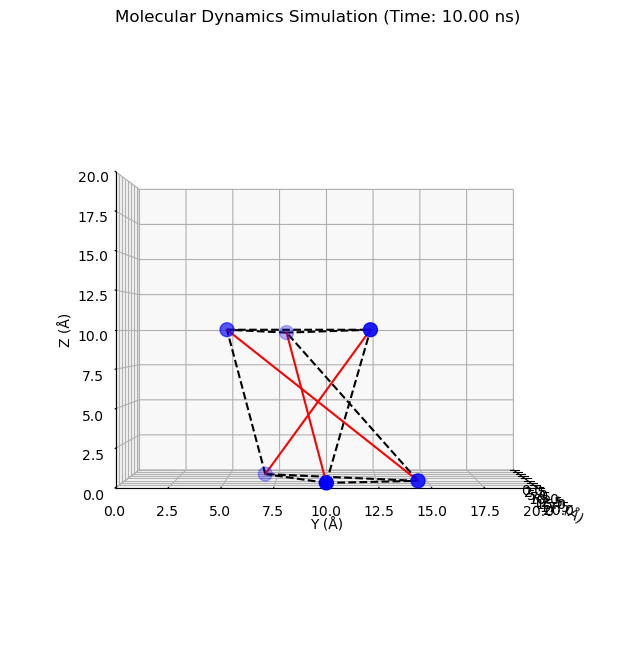

In [79]:
# Simulation parameters
box_size: float = 20.0  # Units in Å
total_time: float = 10.0  # Units in ns
total_steps: int = 1000

# Create atoms
# Geometry
radius: float = 5.0
theta_bottom: float = 0
theta_top: float = np.pi/4
height: float = 10.0
n_polygon: int = 3
side_length: float = radius * 2 * np.sin(np.pi / n_polygon)
initial_positions: np.ndarray = np.array([
    [radius * np.cos(theta_bottom), radius * np.sin(theta_bottom), 0],
    [radius * np.cos(theta_bottom + np.pi * 2 / n_polygon), radius * np.sin(theta_bottom + np.pi * 2 / n_polygon), 0],
    [radius * np.cos(theta_bottom + np.pi * 2 * 2 / n_polygon), radius * np.sin(theta_bottom + np.pi * 2 * 2/ n_polygon), 0],
    [radius * np.cos(theta_top), radius * np.sin(theta_top), height],
    [radius * np.cos(theta_top + np.pi * 2 / n_polygon), radius * np.sin(theta_top + np.pi * 2 / n_polygon), height],
    [radius * np.cos(theta_top + np.pi * 2 * 2 / n_polygon), radius * np.sin(theta_top + np.pi * 2 * 2/ n_polygon), height]
]) + (np.hstack((np.ones([6,2]), np.zeros([6,1])))) * 10
# mountain creases are strings, valley creases are rods
mountain_crease: float = np.linalg.norm(initial_positions[0, :] - initial_positions[n_polygon, :])
valley_crease: float = np.linalg.norm(initial_positions[0, :] - initial_positions[n_polygon + 1, :])
initial_velocities: np.ndarray = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0]
])
mass: float = 1.0  # Units in AMU
epsilon: float = 2.0  # Units in eV
sigma: float = 4.0  # Units in Å

# Create Atom instances
atoms: List[Atom] = [
    Atom(position=pos, velocity=vel, mass=mass, epsilon=epsilon, sigma=sigma)
    for pos, vel in zip(initial_positions, initial_velocities)
]

# LJ potential interaction pairs
lj_pairs = ls_pairs = [
    (0, 1),
    (0, 2), 
    (1, 2), 
    (3, 4),
    (4, 5),
    (5, 3),
    (0, 3),
    (1, 4),
    (2, 5),
]
pairwise_interactions = {(0, 1), (1, 0),
                         (0, 2), (2, 0), 
                         (1, 2), (2, 1), 
                         (3, 4), (4, 3),
                         (4, 5), (5, 4),
                         (5, 3), (3, 5),
                         (0, 3), (3, 0),
                         (1, 4), (4, 1),
                         (2, 5), (5, 2)}
lj_potential = LennardJonesPotential(pairwise_interactions=pairwise_interactions)

# Linear spring potential interaction pairs
ls_pairs = [
    (0, 1), (1, 0),
    (0, 2), (2, 0), 
    (1, 2), (2, 1), 
    (3, 4), (4, 3),
    (4, 5), (5, 4),
    (5, 3), (3, 5),
    (0, 3), (3, 0),
    (1, 4), (4, 1),
    (2, 5), (5, 2)
]
rest_lengths = {
    (0, 1): side_length, (1, 0): side_length,
    (0, 2): side_length, (2, 0): side_length, 
    (1, 2): side_length, (2, 1): side_length, 
    (3, 4): side_length, (4, 3): side_length,
    (4, 5): side_length, (5, 4): side_length,
    (5, 3): side_length, (3, 5): side_length,
    (0, 3): mountain_crease, (3, 0): mountain_crease,
    (1, 4): mountain_crease, (4, 1): mountain_crease,
    (2, 5): mountain_crease, (5, 2): mountain_crease
}
linear_spring_potential = LinearSpringPotential(rest_lengths=rest_lengths, k=2.0)


# Fixed distances
fixed_pairs = [(0, 4),
               (1, 5), 
               (2, 3)]
fixed_distances = {
    (0, 4): valley_crease, (4, 0): valley_crease,
    (1, 5): valley_crease, (5, 1): valley_crease, 
    (2, 3): valley_crease, (3, 2): valley_crease
}
fixed_distance_constraint = FixedDistanceConstraint(fixed_distances=fixed_distances)

# Partial fixed points
partial_fixed_points = {
    1: (None, None, initial_positions[1, 2]),
    2: (None, None, initial_positions[2, 2])
}
partial_fix_constraint = PartialFixConstraint(partial_fixed_points=partial_fixed_points)

# Fixed points constraints
fixed_points = {
    0: initial_positions[0, :]
}
fixed_points_constraint = FixPointConstraint(fixed_points=fixed_points)

# Create the simulator instance
simulator = MolecularDynamicsSimulator(
    atoms=atoms,
    box_size=box_size,
    total_time=total_time,
    total_steps=total_steps,
    potential=lj_potential,
    constraints=[fixed_distance_constraint, fixed_points_constraint, partial_fix_constraint]
)
# Run simulation
simulator.integrate()

# Animate the results
simulator.animate(elev = 0, azim = 0, lj_pairs = lj_pairs, fixed_pairs = fixed_pairs)

In [ ]:
class StretchOnlyPotential(Potential):
    """A potential where the pair only resists stretching beyond a reference length r0.
       If current distance r > r0: force acts to pull them back to r0.
       If r <= r0: no force."""
    def __init__(
        self, 
        rest_lengths: Dict[Tuple[int, int], float], 
        k: float = 1.0, 
        pairwise_interactions: Optional[Set[Tuple[int, int]]] = None
    ) -> None:
        super().__init__(pairwise_interactions)
        self.rest_lengths = rest_lengths
        self.k = k

    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        for atom in atoms:
            atom.force.fill(0.0)

        num_atoms = len(atoms)
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i == j:
                    continue

                # if defined pairwise_interactions，check
                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue

                # 查看是否有参考距离定义，如果没有则不计算力
                if (i, j) not in self.rest_lengths:
                    continue

                atom_i = atoms[i]
                atom_j = atoms[j]
                delta = atom_i.position - atom_j.position
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                r0 = self.rest_lengths[(i, j)]

                if r > r0:
                    # 拉伸状态下产生恢复力
                    dr = r - r0
                    F_mag = self.k * dr
                    force_vector = (F_mag / r) * delta
                    atom_i.force -= force_vector
                    atom_j.force += force_vector
                else:
                    # r <= r0 时无力
                    pass

class CompressOnlyPotential(Potential):
    """A potential where the pair only resists compression below a reference length r0.
       If current distance r < r0: force acts to push them apart back to r0.
       If r >= r0: no force."""
    def __init__(
        self, 
        rest_lengths: Dict[Tuple[int, int], float], 
        k: float = 1.0, 
        pairwise_interactions: Optional[Set[Tuple[int, int]]] = None
    ) -> None:
        super().__init__(pairwise_interactions)
        self.rest_lengths = rest_lengths
        self.k = k

    def compute_forces(self, atoms: List[Atom], box_size: float) -> None:
        for atom in atoms:
            atom.force.fill(0.0)

        num_atoms = len(atoms)
        for i in range(num_atoms):
            for j in range(num_atoms):
                if i == j:
                    continue

                if self.pairwise_interactions is not None and (i, j) not in self.pairwise_interactions:
                    continue

                if (i, j) not in self.rest_lengths:
                    continue

                atom_i = atoms[i]
                atom_j = atoms[j]
                delta = atom_i.position - atom_j.position
                delta -= box_size * np.round(delta / box_size)
                r = float(np.linalg.norm(delta))
                r0 = self.rest_lengths[(i, j)]

                if r < r0:
                    # 压缩状态下产生斥力
                    dr = r0 - r
                    F_mag = self.k * dr
                    force_vector = (F_mag / r) * delta
                    atom_i.force += force_vector
                    atom_j.force -= force_vector
                else:
                    # r >= r0 时无力
                    pass
